In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from keras.utils import plot_model
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import clear_output, display, Math


In [2]:
from keras.datasets import fashion_mnist


# Про dataset `fassion-mnist`

Fashion-MNIST — це набір зображень статей Zalando, що складається з навчального набору з 60 000 прикладів і тестового набору з 10 000 прикладів. Кожен приклад являє собою зображення в градаціях сірого 28x28, пов'язане з міткою з 10 класів:

| Мітка | Опис        | Переклад         |
|-------|-------------|------------------|
| 0     | T-shirt/top | Футболка/сорочка |
| 1     | Trouser     | Штани            |
| 2     | Pullover    | Светр            |
| 3     | Dress       | Плаття           |
| 4     | Coat        | Пальто           |
| 5     | Sandal      | Сандалі          |
| 6     | Shirt       | Сорочка          |
| 7     | Sneaker     | Кросовки         |
| 8     | Bag         | Сумка            |
| 9     | Ankle boot  | Чоботи           |

# Константи

In [3]:
class_labels = {0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress',
                4: 'Coat', 5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'}
input_shape = (28, 28, 1)
num_classes = 10


# Підготовка навчального та тестового наборів

In [4]:
# Завантажуємо датасет і розділимо його на навчальну та тестову вибірки.
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Перетворюємо цілочисельні пікселі на тип float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Нормалізуємо значення пікселів, щоб значення пікселів знаходилось у проміжку від 0 до 1, розділивши яскравість кожного пікселя на 255.
x_train, x_test = x_train / 255., x_test / 255.


# Огляд даних

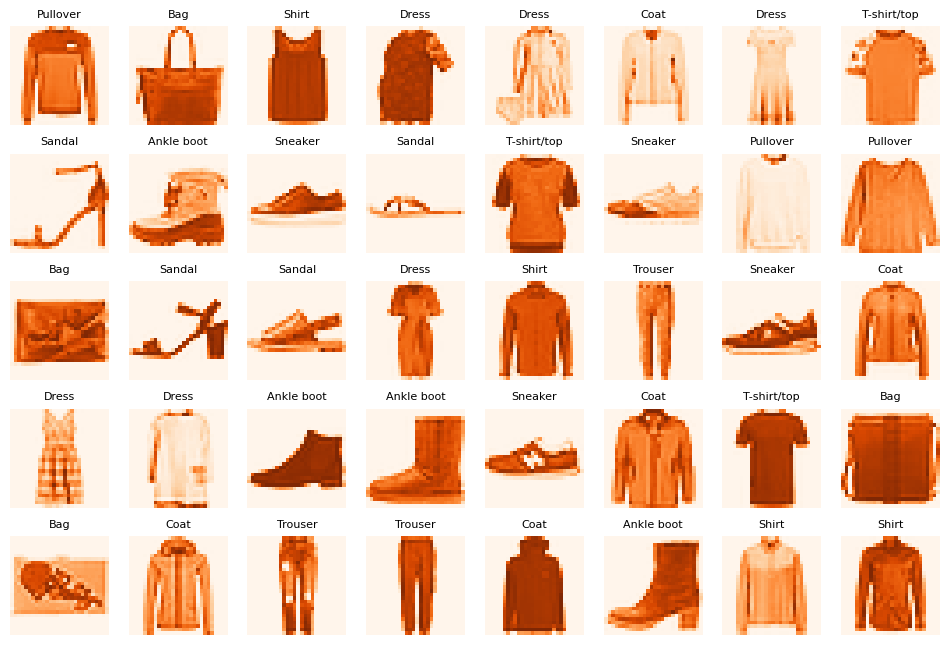

In [5]:
number_of_images = 40
f, ax = plt.subplots(5, 8, figsize=(12, 8))

for i, sample_index in enumerate(np.random.randint(1, x_test.shape[0], number_of_images)):
    test_image = x_test[sample_index].reshape(1, -1)
    test_item = y_test[sample_index]
    ax[i//8, i % 8].imshow(test_image[0].reshape((28, 28)), cmap="Oranges")
    ax[i//8, i % 8].axis('off')
    ax[i//8, i %
        8].set_title(f"{class_labels.get(test_item)}", fontsize=8)
plt.show()


# Побудова Архітектури нейронної мережі (моделі)

1. [Фуннкції активації](https://keras.io/api/layers/activations/)
2. [Оптимізатори](https://keras.io/api/optimizers/)
3. [Функції втрат](https://keras.io/api/losses/)
4. [Метрики](https://keras.io/api/metrics/)

In [6]:
# Побудова архітектури моделі
from tensorflow.keras.callbacks import LearningRateScheduler

keras.utils.set_random_seed(42)


def lr_scheduler(epoch, lr):
    new_lr = lr * 0.5
    return new_lr


lr_callback = LearningRateScheduler(lr_scheduler)

# Побудова архітектури моделі


def create_model(learning_rate, l2_parameter):
    model = keras.Sequential()
    model.add(layers.Flatten(input_shape=(28, 28, 1)))
    model.add(layers.Dense(128, activation='relu',
        kernel_regularizer=regularizers.l2(l2_parameter)))
    model.add(layers.Dropout(0.25))
    model.add(layers.Dense(64, activation='relu',
        kernel_regularizer=regularizers.l2(l2_parameter)))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(10, activation='softmax'))

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'],
                  )
    return model


# Гіперпараметри

Друге правило радіоаматора: не можна крутити дві ручки одночасно!

In [7]:
epochs = 25
steps_per_epoch = 1_000
batch_size = 64*2
l2_parameter = 1e-4
learning_rate = 1e-3
model = create_model(learning_rate, l2_parameter)

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 10)                650       
                                                                 
Total params: 109386 (427.29 KB)
Trainable params: 10938

# Навчання моделі

In [8]:
# Перемішаємо тренувальні дані
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(256).prefetch(1)


# Навчання моделі
history = model.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_test, y_test)
)

# Оцінка моделі на тестовому наборі даних
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=1)
print(f'\nТочність на тестовому наборі: {test_accuracy:.2f}')


Epoch 1/25
469/469 [==============================] - 6s 10ms/step - loss: 0.6658 - accuracy: 0.7740 - val_loss: 0.4847 - val_accuracy: 0.8421
Epoch 2/25
469/469 [==============================] - 3s 7ms/step - loss: 0.4747 - accuracy: 0.8421 - val_loss: 0.4503 - val_accuracy: 0.8483
Epoch 3/25
469/469 [==============================] - 2s 5ms/step - loss: 0.4361 - accuracy: 0.8555 - val_loss: 0.4309 - val_accuracy: 0.8542
Epoch 4/25
469/469 [==============================] - 2s 5ms/step - loss: 0.4173 - accuracy: 0.8637 - val_loss: 0.4150 - val_accuracy: 0.8624
Epoch 5/25
469/469 [==============================] - 2s 4ms/step - loss: 0.4015 - accuracy: 0.8684 - val_loss: 0.4053 - val_accuracy: 0.8666
Epoch 6/25
469/469 [==============================] - 2s 5ms/step - loss: 0.3909 - accuracy: 0.8725 - val_loss: 0.4035 - val_accuracy: 0.8676
Epoch 7/25
469/469 [==============================] - 3s 7ms/step - loss: 0.3814 - accuracy: 0.8760 - val_loss: 0.3887 - val_accuracy: 0.8773
Epoch

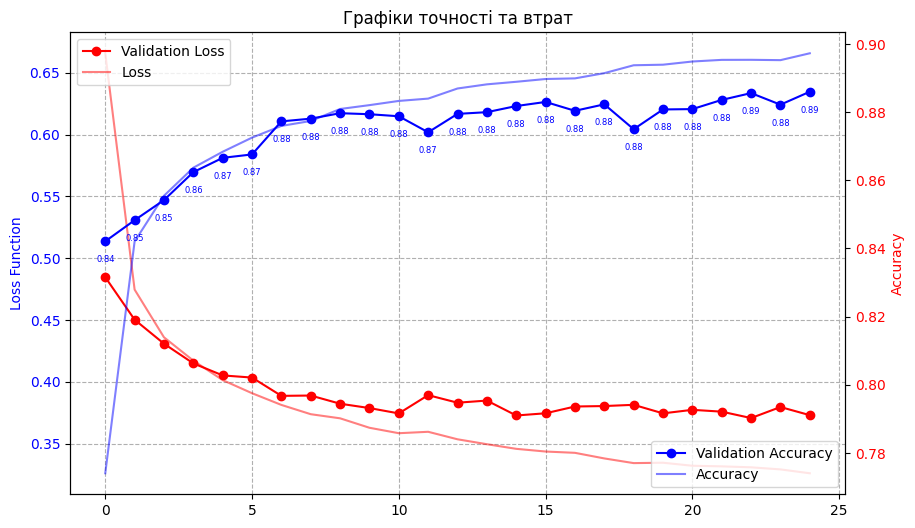

In [9]:
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(history.history['val_loss'], label='Validation Loss', marker='o', color='r')
ax1.plot(history.history['loss'], label='Loss', color='r', alpha=0.5)
ax1.set_ylabel('Loss Function', color='b')
ax1.tick_params(axis='y', labelcolor='b')

ax2 = ax1.twinx()

ax2.plot(history.history['val_accuracy'], label='Validation Accuracy',  marker='o', color='b')
ax2.plot(history.history['accuracy'], label='Accuracy', color='b', alpha=0.5)
                         
for i, acc in enumerate(history.history['val_accuracy']):
    ax2.annotate(f'{acc:.2f}', (i, acc), textcoords="offset points", xytext=(0, -15), ha='center', c='b', fontsize=6)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy', color='r')
ax2.tick_params(axis='y', labelcolor='r')
ax1.grid(True, linestyle='--') 

ax1.legend(loc='upper left')
ax2.legend(loc='lower right')

plt.title('Графіки точності та втрат')

plt.show()